# 🎓 Assignment 3
## ✅ Rename the filename with your roll number. E.g. if your roll number is `MT24003` then rename the file `MT24003_a3.ipynb` before submitting.
## ✅ Write code only in the sections marked with `# YOUR CODE HERE`. No, you can NOT write code anywhere else.
## ✅ Download and extract the `MLA3_DATA.zip` folder next to this file. If you extract it correctly, you will have a `MLA3_DATA` folder next to this file.
## ❌ Do not modify any other function or class definitions; doing so may lead to the autograder failing to judge your submission, resulting in a zero.
## ❌ Deleting or adding new cells may lead to the `autograder` failing to judge your submission, resulting in a zero. Even if a cell is empty, do NOT delete it.
## ❌ Do NOT install / import any other libraries. You should be able to solve all the questions using only the libraries imported below.


In [27]:
# =======================
# DO NOT MODIFY THIS CELL
# =======================

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import scipy

# Base paths
PATH_TO_DATA_DIR = "./MLA3_DATA"
PATH_TO_TRAIN_DIR = os.path.join(PATH_TO_DATA_DIR, "TRAIN")
PATH_TO_TEST_DIR = os.path.join(PATH_TO_DATA_DIR, "TEST")

# Train and Test CSV paths
PATH_TO_TRAIN_FILE = os.path.join(PATH_TO_TRAIN_DIR, "train.csv")
PATH_TO_STUDENT_TEST_FILE = os.path.join(PATH_TO_TEST_DIR, "student_test.csv")
PATH_TO_HIDDEN_TEST_SAMPLE_FILE = os.path.join(PATH_TO_TEST_DIR, "hidden_test_sample.csv")


# `q0` EDA

* The dataset in this assignment mimics a real-world dataset and contains various artifacts, such as missing values, categorical features, and outliers.
* Your task is to train three models: Decision Tree, Gradient Boosting, and SVM. The trained models will be tested on both a visible test set and a hidden test set, which will not be accessible to you.
* To help you apply consistent preprocessing across the train, student test, and hidden test sets, we provide a very small sample of the hidden test data (3 rows). **This sample is only for sanity-checking your preprocessing code; your marks will be based on the performance of your notebook on the full hidden test dataset (~100 rows) when it is re-run after the submission deadline.**
* Additionally, the given hidden test sample does not contain the label column, so you will not be able to evaluate your model on it. Think of this dataset as the *live* data your model will experience after deployment in the wild.
* This assignment is designed to build your intuition for real-world data, highlight the importance of EDA and feature engineering, and illustrate concepts such as generalizability and overfitting.
* Given the peculiar nature of the dataset, you are strongly encouraged to do it for your own understanding.

### Grading:
* This question is not graded.

In [28]:
# YOUR CODE HERE

# `q1` Data Loading, Preprocessing, and Feature Engineering

* You are free to perform any preprocessing and feature engineering you want.
* Populate the `Dataset` class with your preprocessing + feature engineering code.

### Grading:
* This question is not graded but will be used later in graded questions.

In [29]:
class Dataset:
    """
    CSV loader that returns X, y as numpy arrays for sklearn. Label column is 'class'.
    """

    def __init__(self, filepath: str, preprocessor: sklearn.compose.ColumnTransformer = None, do_fit: bool = True):
        """
        filepath: path to CSV with features + a label column named 'class'
        preprocessor: optional fitted sklearn ColumnTransformer (provide for test/hidden runs)
        do_fit: whether to fit the preprocessor on this data
        """
        self.filepath = filepath
        self.preprocessor = preprocessor
        self.features = None
        self.labels = None
        self._load_and_preprocess(do_fit)

    def _load_and_preprocess(self, do_fit: bool = True):
        """
        Load CSV, split on label 'class', apply (or fit+apply) preprocessor,
        and populate self.features, self.labels, self.feature_names, self.preprocessor.
        """
        # YOUR CODE HERE
        df = pd.read_csv(self.filepath)

        if "class" in df.columns:
            y = df["class"].values
            X_df = df.drop(columns=["class"])
        else:
            y = None
            X_df = df

        feature_cols = X_df.columns.tolist()
        num_cols = [c for c in feature_cols if np.issubdtype(X_df[c].dtype, np.number)] #numbers and categories
        cat_cols = [c for c in feature_cols if c not in num_cols]

        for c in num_cols:
            if X_df[c].isna().all():
                continue
            low, high = X_df[c].quantile([0.01, 0.99]) 
            # low, high = X_df[c].quantile([0.1, 0.9]) 
            X_df[c] = X_df[c].clip(low, high) #clipping here]
            X_df[c] = pd.to_numeric(X_df[c], errors="coerce")
            # X_df[c] = pd.to_numeric(X_df[c], errors="ignore")
            if abs(X_df[c].skew()) > 1:
                X_df[c] = np.log1p(np.abs(X_df[c]))

        le = sklearn.preprocessing.LabelEncoder()

        low_card = [c for c in cat_cols if X_df[c].nunique(dropna=False) <= 8]
        # low_card = [c for c in cat_cols if X_df[c].nunique() <= 11]
        high_card = [c for c in cat_cols if c not in low_card]

        for c in high_card:
            X_df[c] = X_df[c].astype(str)
            X_df[c] = le.fit_transform(X_df[c].fillna("MISSING")) #fill in with MISSING

        if self.preprocessor is None:
            numeric_pipe = sklearn.pipeline.Pipeline(steps=[
                ("imputer", sklearn.impute.SimpleImputer(strategy="median")), #try with average too
                ("scaler", sklearn.preprocessing.RobustScaler()),
            ])
            try:
                ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore", sparse_output=True)
            except TypeError:
                ohe = sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=True)
            cat_pipe = sklearn.pipeline.Pipeline(steps=[
                ("imputer", sklearn.impute.SimpleImputer(strategy="most_frequent")),
                # ("imputer", sklearn.impute.SimpleImputer(strategy="median")),
                ("ohe", ohe),
            ])
            self.preprocessor = sklearn.compose.ColumnTransformer(
                transformers=[
                    ("num", numeric_pipe, num_cols),
                    ("cat", cat_pipe, low_card),
                ],
                sparse_threshold=0.3,
            )

        if do_fit:
            X = self.preprocessor.fit_transform(X_df)
        else:
            X = self.preprocessor.transform(X_df)

        feature_names = []
        feature_names.extend(num_cols)
        try:
            ohe = self.preprocessor.named_transformers_["cat"].named_steps["ohe"]
            cat_names = ohe.get_feature_names_out(input_features=low_card).tolist()
            feature_names.extend(cat_names)
        except Exception:
            pass
        feature_names.extend(high_card)

        self.feature_names = feature_names

        self.features = X
        self.labels = y

    def get_features_and_labels(self):
        """
        Return (X, y) where X is 2D numpy array and y is 1D numpy array.
        """
        return self.features, self.labels


In [30]:
# =======================
# DO NOT MODIFY THIS CELL
# =======================

train_ds = Dataset(PATH_TO_TRAIN_FILE, do_fit=True)
X_train, y_train = train_ds.get_features_and_labels()

test_ds = Dataset(
    PATH_TO_STUDENT_TEST_FILE,
    preprocessor=train_ds.preprocessor,
    do_fit=False
)
X_test, y_test = test_ds.get_features_and_labels()

hidden_ds = Dataset(
    PATH_TO_HIDDEN_TEST_SAMPLE_FILE,
    preprocessor=train_ds.preprocessor,
    do_fit=False
)
X_hidden, y_hidden = hidden_ds.get_features_and_labels()

print(f"[Train] X: {X_train.shape}, y: {y_train.shape}")
print(f"[Student Test] X: {X_test.shape}, y: {y_test.shape}")
print(f"[Hidden SAMPLE] X: {X_hidden.shape}, y: {y_hidden}") # NOTE: this is not the full hidden test set; only 3 rows and will not contain labels

[Train] X: (510, 21), y: (510,)
[Student Test] X: (52, 21), y: (52,)
[Hidden SAMPLE] X: (3, 21), y: None


/var/folders/s7/1dm6kzqs2qj7l89_hbhmmvwh0000gn/T/ipykernel_25569/4153054665.py:42: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[c] = X_df[c].clip(low, high) #clipping here]


# `q2` Model Training and Evaluation

* The `ModelTrainer` class is already implemented for you and does not need to be modified.
* Your task in the following questions will be to define and implement three functions: `get_decision_tree_classifier`, `get_boosting_classifier`, and `get_svm_classifier`.  
* Inside each of these functions, you will instantiate the corresponding scikit-learn model and tune its hyperparameters to achieve the best performance.


### Grading:
* Your final grade for each of the three models (**Decision Tree**, **Gradient Boosting**, and **SVM**) will be based on its F1-score on the hidden test set, according to the rubric below. The maximum score for each model is 2 marks.

    | F1-Score on Hidden Test Set | Marks Awarded |
    | :-------------------------: | :-----------: |
    |        `0.95 - 1.00`        |      2.0      |
    |        `0.90 - 0.94`        |      1.5      |
    |        `0.85 - 0.89`        |      1.0      |
    |        `0.75 - 0.84`        |      0.5      |
    |          `< 0.75`           |      0.0      |
        

In [31]:
# =======================
# DO NOT MODIFY THIS CELL
# =======================

class ModelTrainer:
    """
    Trains, evaluates, and runs predictions with a scikit-learn classifier,
    taking Dataset objects as direct input.
    """

    def __init__(self, classifier):
        """
        Initializes the trainer with an unfitted sklearn classifier object.
        """
        if not all(hasattr(classifier, attr) for attr in ['fit', 'predict']):
            raise TypeError("The provided object is not a valid sklearn classifier.")
        self.classifier = classifier
        self.training_feature_names = None

    def train(self, train_dataset):
        """
        Fits the classifier on the provided training Dataset object.
        """
        X_train, y_train = train_dataset.get_features_and_labels()
        self.training_feature_names = train_dataset.feature_names
        self.classifier.fit(X_train, y_train)

    def evaluate(self, test_dataset, title_prefix: str = ""):
        """
        Evaluates the trained classifier on a test Dataset object.
        """
        if not hasattr(self.classifier, "classes_"):
            raise ValueError("Classifier has not been trained. Call .train() first.")

        X_test, y_test = test_dataset.get_features_and_labels()
        y_pred = self.classifier.predict(X_test)

        acc = sklearn.metrics.accuracy_score(y_test, y_pred)
        pre = sklearn.metrics.precision_score(y_test, y_pred, zero_division=0)
        rec = sklearn.metrics.recall_score(y_test, y_pred, zero_division=0)
        f1 = sklearn.metrics.f1_score(y_test, y_pred, zero_division=0)

        model_name = self.classifier.__class__.__name__
        header = f"{title_prefix} {model_name} Results".strip()
        print(header)
        print("-" * len(header))
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {pre:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-score : {f1:.4f}")

        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4.5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.classifier.classes_, yticklabels=self.classifier.classes_)
        plt.title(f"{model_name} Confusion Matrix ({title_prefix.strip()})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    def predict(self, dataset):
        """
        Generates predictions for a given Dataset object.
        """
        if not hasattr(self.classifier, "classes_"):
            raise ValueError("Classifier has not been trained. Call .train() first.")

        X_features, _ = dataset.get_features_and_labels()
        return self.classifier.predict(X_features)

In [32]:
def get_decision_tree_classifier() -> sklearn.tree.DecisionTreeClassifier:
    """
    Return a DecisionTreeClassifier with student-selected hyperparameters.
    """
    clf = None
    # YOUR CODE HERE
    clf = sklearn.tree.DecisionTreeClassifier(
        criterion="entropy",
        max_depth=15,
        # max_depth=14,
        # max_depth=16,
        # max_depth=13,
        min_samples_leaf=1,
        min_samples_split=4,
        max_features="sqrt",
        class_weight="balanced",
        random_state=42
    )
    return clf

In [33]:
def get_boosting_classifier() -> sklearn.ensemble.GradientBoostingClassifier:
    """
    Return a GradientBoostingClassifier with student-selected hyperparameters.
    """
    clf = None
    # YOUR CODE HERE
    clf = sklearn.ensemble.GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.08,
    # learning_rate=0.07,
    # learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    min_samples_leaf=2,
    random_state=42
)
    return clf

In [34]:
def get_svm_classifier() -> sklearn.svm.SVC:
    """
    Return an SVC (Support Vector Classifier) with student-selected hyperparameters.
    """
    clf = None
    # YOUR CODE HERE
    clf = sklearn.svm.SVC(
       kernel="rbf",
       C=1.8,    
       #C = 1.9               
       gamma=0.04,
       #gamma = 0.05
       class_weight=None, 
       probability=False,  
       random_state=42
   )
    return clf

Visible Test DecisionTreeClassifier Results
-------------------------------------------
Accuracy : 0.8269
Precision: 0.7619
Recall   : 0.8000
F1-score : 0.7805


/var/folders/s7/1dm6kzqs2qj7l89_hbhmmvwh0000gn/T/ipykernel_25569/4153054665.py:42: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[c] = X_df[c].clip(low, high) #clipping here]


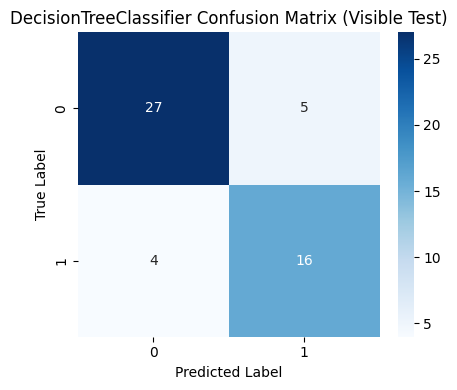

Visible Test GradientBoostingClassifier Results
-----------------------------------------------
Accuracy : 0.8846
Precision: 0.8500
Recall   : 0.8500
F1-score : 0.8500


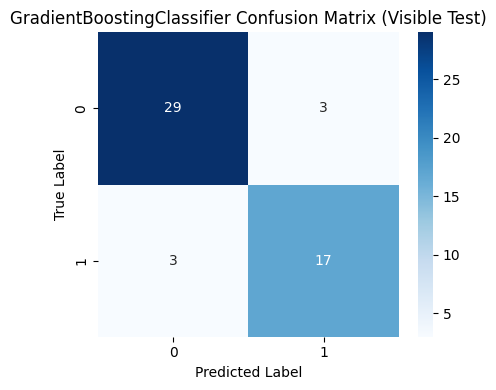

Visible Test SVC Results
------------------------
Accuracy : 0.8077
Precision: 0.7273
Recall   : 0.8000
F1-score : 0.7619


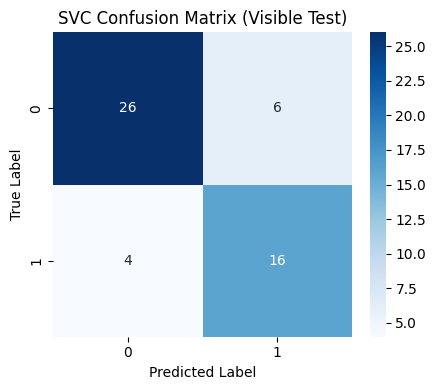

In [35]:
train_dataset = Dataset(PATH_TO_TRAIN_FILE, do_fit=True)
test_dataset = Dataset(PATH_TO_STUDENT_TEST_FILE, preprocessor=train_dataset.preprocessor, do_fit=False)
hidden_dataset = Dataset(PATH_TO_HIDDEN_TEST_SAMPLE_FILE, preprocessor=train_dataset.preprocessor, do_fit=False)

dt_trainer = ModelTrainer(get_decision_tree_classifier())
dt_trainer.train(train_dataset)
dt_trainer.evaluate(test_dataset, title_prefix="Visible Test")
dt_predictions = dt_trainer.predict(hidden_dataset)

gb_trainer = ModelTrainer(get_boosting_classifier())
gb_trainer.train(train_dataset)
gb_trainer.evaluate(test_dataset, title_prefix="Visible Test")
gb_predictions = gb_trainer.predict(hidden_dataset)

svm_trainer = ModelTrainer(get_svm_classifier())
svm_trainer.train(train_dataset)
svm_trainer.evaluate(test_dataset, title_prefix="Visible Test")
svm_predictions = svm_trainer.predict(hidden_dataset)